In [77]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from itertools import product

In [78]:
frb_data = pd.read_csv('frb-data.csv')
frb_data['Repeater'] = frb_data['Repeater'].map({'Yes': 1, 'No': 0})
frb_data['Repeater'] = frb_data['Repeater'].fillna(0)
frb_data['Repeater'] = frb_data['Repeater'].astype(int)

In [79]:
# Select numerical columns that are relevant for VAE training
# features = ['Observing_band', 'MJD', 'GL', 'GB', 'SNR', 'DM_SNR', 'DM_SNR_err', 'DM_alig', 'DM_alig_err', 'Flux_density', 
#             'Flux_density_err', 'Width', 'Width_err', 'Freq_high', 'Freq_low', 'Freq_peak', 'Fluence', 'Fluence_err', 'Energy', 
#             'Energy_err', 'Polar_l', 'Polar_l_err', 'Polar_c', 'Polar_c_err', 'RM_syn', 'RM_syn_err', 'RM_QUfit', 'RM_QUfit_err', 'Scatt_t', 'Scatt_t_err', 'Scin_f', 'Scin_f_err',]

labels = frb_data['Repeater']

features = ['Observing_band', 'MJD', 'GL', 'GB', 'SNR', 'DM_SNR', 'DM_alig', 'Flux_density', 
             'Width', 'Freq_high', 'Freq_low', 'Freq_peak', 'Fluence', 'Energy', 
             'Polar_l',  'Polar_c', 'RM_syn',  'RM_QUfit', 'Scatt_t', 'Scin_f',]

# Function to clean numerical strings and convert to float
def clean_numeric_value(value):
    if type(value)==str and len(value.strip()) > 0:
        try:
            if '/' in value:
                value = value.split('/')[0]
            if '-' in value and not '+' in value:
                value = value.split('-')[0]
            if value[0] == '+':
                value = value[1:]
                value.split('/')
                value = value[0]
            if value[0] == '<':
                value = value[1:]
            if value[0] == '>':
                value = value[1:]
            return float(value)
        except:
            # print(f"Error: {value}")
            return np.nan
    try:
        return float(value)
    except:
        return np.nan

for col in frb_data[features].columns:
    frb_data[col] = frb_data[col].apply(clean_numeric_value)

In [80]:
frb_data_clean = frb_data[features].fillna(0)
scaler = StandardScaler()
frb_data_scaled = scaler.fit_transform(frb_data_clean)

train_data, val_data, train_labels, val_labels = train_test_split(
    frb_data_scaled, labels, test_size=0.2, random_state=42, stratify=labels
)

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

# Create datasets and dataloaders
batch_size = 64
train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [81]:
class SupervisedVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.3, activation=nn.LeakyReLU(0.1)):
        super(SupervisedVAE, self).__init__()
        
        self.activation = activation
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate)
        )
        
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, input_dim)
        )
        
        # Classification head for binary classification
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        class_prob = self.classifier(z)
        return recon_x, mu, logvar, class_prob

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = frb_data_scaled.shape[1]
hidden_dim = 256
latent_dim = 10
patience = 4
num_epochs = 150

In [83]:
reconstruction_loss_fn = nn.MSELoss(reduction='sum')
classification_loss_fn = nn.BCELoss()

def loss_function(recon_x, x, mu, logvar, class_prob, labels, beta, gamma):
    recon_loss = reconstruction_loss_fn(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    class_loss = classification_loss_fn(class_prob, labels.unsqueeze(1).float())
    total_loss = recon_loss + beta * kl_loss + gamma * class_loss
    return total_loss, recon_loss, kl_loss, class_loss



In [84]:
def train_supervised(model, optimizer, scheduler, epoch, beta, gamma):
    model.train()
    train_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    
    correct = 0
    total = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, class_logits = model(data)
        
        # Supervised loss function
        loss, recon_loss, kl_loss, classification_loss = loss_function(
            recon_batch, data, mu, logvar, class_logits, labels, beta, gamma
        )
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_loss_total += kl_loss.item()
        classification_loss_total += classification_loss.item()
        
        predicted = (class_logits > 0.5).float()
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    # Calculate average loss and accuracy for the epoch
    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon = recon_loss_total / len(train_loader.dataset)
    avg_kl = kl_loss_total / len(train_loader.dataset)
    avg_class = classification_loss_total / len(train_loader.dataset)
    accuracy = correct / total
    
    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
          f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy

def validate_supervised(model, scheduler, optimizer, epoch, beta, gamma):
    model.eval()
    val_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            recon_batch, mu, logvar, class_logits = model(data)
            
            loss, recon_loss, kl_loss, classification_loss = loss_function(
                recon_batch, data, mu, logvar, class_logits, labels, beta, gamma
            )
            
            val_loss += loss.item()
            recon_loss_total += recon_loss.item()
            kl_loss_total += kl_loss.item()
            classification_loss_total += classification_loss.item()
            
            predicted = (class_logits > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    
    avg_loss = val_loss / len(val_loader.dataset)
    avg_recon = recon_loss_total / len(val_loader.dataset)
    avg_kl = kl_loss_total / len(val_loader.dataset)
    avg_class = classification_loss_total / len(val_loader.dataset)
    accuracy = correct / total
    
    print(f'====> Validation loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
          f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy


def early_stopping(val_losses, patience):
    if len(val_losses) > patience:
        if all(val_losses[-i-1] <= val_losses[-i] for i in range(1, patience+1)):
            return True
    return False



In [85]:
def evaluate_classifier(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            labels = labels.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, class_report, conf_matrix, f1  # Return F1 score as well


In [86]:
dropout_rate = 0.3
learning_rate = 1e-3

param_grid = {
    "hidden_dim": [128, 256],
    "latent_dim": [5, 10, 20],
    "beta": [0.5, 1, 2],
    "gamma": [0.5, 1, 2]
}

best_f1_score = 0
best_params = {}

for hidden_dim, latent_dim, beta, gamma in product(
    param_grid["hidden_dim"], param_grid["latent_dim"], param_grid["beta"], param_grid["gamma"]):
    
    # Initialize model with current hyperparameters
    model = SupervisedVAE(input_dim, hidden_dim, latent_dim, dropout_rate).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience, verbose=True)
    val_losses = []
    
    patience = 4
    num_epochs = 50 
    
    for epoch in range(1, num_epochs + 1):
        train_loss, _, _, _, _ = train_supervised(model, optimizer, scheduler, epoch, beta, gamma)
        val_loss, _, _, _, val_accuracy = validate_supervised(model, optimizer, scheduler, epoch, beta, gamma)
        val_losses.append(val_loss)

        scheduler.step(val_loss)
        
        if early_stopping(val_losses, patience):
            print(f"Early stopping triggered at epoch {epoch}")
            break

    val_accuracy, val_class_report, val_conf_matrix, val_f1_score = evaluate_classifier(model, val_loader, device)


    # Check if this is the best model so far
    if val_f1_score > best_f1_score:
        best_f1_score = val_f1_score
        best_params = {
            "hidden_dim": hidden_dim,
            "latent_dim": latent_dim,
            "beta": beta,
            "gamma": gamma
        }

print("Best F1 Score:", best_f1_score)
print("Best Parameters:", best_params)


/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [0/6931 (0%)]	Loss: 54.658291
Train Epoch: 1 [6400/6931 (92%)]	Loss: 11.402921
====> Epoch: 1 Average loss: 19.7345, Recon: 18.5008, KL: 2.4596, Class: 0.0077, Accuracy: 0.8220
====> Validation loss: 12.2510, Recon: 10.8812, KL: 2.7334, Class: 0.0063, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 35.064201
Train Epoch: 2 [6400/6931 (92%)]	Loss: 11.877019
====> Epoch: 2 Average loss: 16.0800, Recon: 14.0745, KL: 4.0052, Class: 0.0057, Accuracy: 0.8629
====> Validation loss: 10.0027, Recon: 8.1164, KL: 3.7675, Class: 0.0050, Accuracy: 0.8656
Train Epoch: 3 [0/6931 (0%)]	Loss: 10.994431
Train Epoch: 3 [6400/6931 (92%)]	Loss: 17.008389
====> Epoch: 3 Average loss: 14.6621, Recon: 12.4560, KL: 4.4073, Class: 0.0050, Accuracy: 0.8696
====> Validation loss: 9.1279, Recon: 7.1148, KL: 4.0217, Class: 0.0044, Accuracy: 0.8719
Train Epoch: 4 [0/6931 (0%)]	Loss: 22.146376
Train Epoch: 4 [6400/6931 (92%)]	Loss: 26.284178
====> Epoch: 4 Average loss: 13.9168, Recon: 11.5801, KL:

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 37.651257
====> Epoch: 1 Average loss: 19.6914, Recon: 18.3829, KL: 2.6025, Class: 0.0073, Accuracy: 0.8488
====> Validation loss: 11.7519, Recon: 10.1717, KL: 3.1484, Class: 0.0061, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 40.750977
Train Epoch: 2 [6400/6931 (92%)]	Loss: 8.216881
====> Epoch: 2 Average loss: 15.8744, Recon: 13.8466, KL: 4.0440, Class: 0.0058, Accuracy: 0.8625
====> Validation loss: 10.7052, Recon: 9.0965, KL: 3.2065, Class: 0.0055, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 14.715816
Train Epoch: 3 [6400/6931 (92%)]	Loss: 9.597909
====> Epoch: 3 Average loss: 14.7030, Recon: 12.4576, KL: 4.4805, Class: 0.0051, Accuracy: 0.8634
====> Validation loss: 9.5269, Recon: 7.3980, KL: 4.2485, Class: 0.0047, Accuracy: 0.8661
Train Epoch: 4 [0/6931 (0%)]	Loss: 60.418736
Train Epoch: 4 [6400/6931 (92%)]	Loss: 7.379239
====> Epoch: 4 Average loss: 13.9238, Recon: 11.5828, KL: 4.6723, Class: 0.0048, Accuracy: 0.8762
====> V

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 9.270339
====> Epoch: 1 Average loss: 19.9294, Recon: 18.6790, KL: 2.4700, Class: 0.0077, Accuracy: 0.8259
====> Validation loss: 12.6345, Recon: 11.1877, KL: 2.8694, Class: 0.0060, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 13.508559
Train Epoch: 2 [6400/6931 (92%)]	Loss: 8.220877
====> Epoch: 2 Average loss: 16.1812, Recon: 14.1415, KL: 4.0572, Class: 0.0056, Accuracy: 0.8628
====> Validation loss: 10.6829, Recon: 8.9739, KL: 3.3977, Class: 0.0051, Accuracy: 0.8632
Train Epoch: 3 [0/6931 (0%)]	Loss: 7.567445
Train Epoch: 3 [6400/6931 (92%)]	Loss: 7.284248
====> Epoch: 3 Average loss: 14.7476, Recon: 12.4524, KL: 4.5710, Class: 0.0049, Accuracy: 0.8743
====> Validation loss: 9.8842, Recon: 8.0774, KL: 3.5952, Class: 0.0046, Accuracy: 0.8759
Train Epoch: 4 [0/6931 (0%)]	Loss: 13.131407
Train Epoch: 4 [6400/6931 (92%)]	Loss: 58.403866
====> Epoch: 4 Average loss: 13.9035, Recon: 11.5322, KL: 4.7242, Class: 0.0046, Accuracy: 0.8869
====> Va

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 11.841315
====> Epoch: 1 Average loss: 20.4276, Recon: 18.7364, KL: 1.6873, Class: 0.0077, Accuracy: 0.8442
====> Validation loss: 13.6298, Recon: 11.8392, KL: 1.7874, Class: 0.0065, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 32.236240
Train Epoch: 2 [6400/6931 (92%)]	Loss: 37.708771
====> Epoch: 2 Average loss: 17.5389, Recon: 14.9598, KL: 2.5761, Class: 0.0060, Accuracy: 0.8625
====> Validation loss: 12.2872, Recon: 9.8732, KL: 2.4113, Class: 0.0054, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 12.642334
Train Epoch: 3 [6400/6931 (92%)]	Loss: 9.960442
====> Epoch: 3 Average loss: 16.5187, Recon: 13.6558, KL: 2.8602, Class: 0.0054, Accuracy: 0.8634
====> Validation loss: 11.4012, Recon: 8.8005, KL: 2.5982, Class: 0.0051, Accuracy: 0.8673
Train Epoch: 4 [0/6931 (0%)]	Loss: 8.222886
Train Epoch: 4 [6400/6931 (92%)]	Loss: 11.828484
====> Epoch: 4 Average loss: 16.0432, Recon: 13.0038, KL: 3.0368, Class: 0.0052, Accuracy: 0.8687
====>

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 13.344478
====> Epoch: 1 Average loss: 20.6843, Recon: 19.0463, KL: 1.6306, Class: 0.0075, Accuracy: 0.8489
====> Validation loss: 13.7639, Recon: 12.3257, KL: 1.4317, Class: 0.0065, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 28.013792
Train Epoch: 2 [6400/6931 (92%)]	Loss: 11.169806
====> Epoch: 2 Average loss: 17.6172, Recon: 15.1482, KL: 2.4629, Class: 0.0061, Accuracy: 0.8625
====> Validation loss: 12.4110, Recon: 10.5204, KL: 1.8847, Class: 0.0060, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 15.246457
Train Epoch: 3 [6400/6931 (92%)]	Loss: 15.006359
====> Epoch: 3 Average loss: 16.6367, Recon: 13.8687, KL: 2.7623, Class: 0.0057, Accuracy: 0.8619
====> Validation loss: 11.5310, Recon: 9.0826, KL: 2.4429, Class: 0.0055, Accuracy: 0.8632
Train Epoch: 4 [0/6931 (0%)]	Loss: 11.345625
Train Epoch: 4 [6400/6931 (92%)]	Loss: 11.669772
====> Epoch: 4 Average loss: 16.0934, Recon: 13.1944, KL: 2.8935, Class: 0.0055, Accuracy: 0.8652
==

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 19.088131
====> Epoch: 1 Average loss: 21.0878, Recon: 19.5325, KL: 1.5394, Class: 0.0080, Accuracy: 0.8158
====> Validation loss: 13.5363, Recon: 11.7679, KL: 1.7556, Class: 0.0064, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 17.548960
Train Epoch: 2 [6400/6931 (92%)]	Loss: 10.267929
====> Epoch: 2 Average loss: 17.5015, Recon: 14.8040, KL: 2.6854, Class: 0.0060, Accuracy: 0.8624
====> Validation loss: 12.3830, Recon: 10.1685, KL: 2.2031, Class: 0.0057, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 12.215723
Train Epoch: 3 [6400/6931 (92%)]	Loss: 13.670156
====> Epoch: 3 Average loss: 16.4535, Recon: 13.4912, KL: 2.9515, Class: 0.0054, Accuracy: 0.8621
====> Validation loss: 11.5096, Recon: 8.8605, KL: 2.6388, Class: 0.0052, Accuracy: 0.8644
Train Epoch: 4 [0/6931 (0%)]	Loss: 9.377383
Train Epoch: 4 [6400/6931 (92%)]	Loss: 9.107948
====> Epoch: 4 Average loss: 15.9475, Recon: 12.7935, KL: 3.1435, Class: 0.0053, Accuracy: 0.8680
====

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 12.121883
====> Epoch: 1 Average loss: 22.0916, Recon: 20.3447, KL: 0.8717, Class: 0.0069, Accuracy: 0.8624
====> Validation loss: 15.4273, Recon: 13.9724, KL: 0.7259, Class: 0.0064, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 15.233563
Train Epoch: 2 [6400/6931 (92%)]	Loss: 12.799550
====> Epoch: 2 Average loss: 19.5495, Recon: 17.0421, KL: 1.2521, Class: 0.0063, Accuracy: 0.8625
====> Validation loss: 14.9621, Recon: 13.4976, KL: 0.7307, Class: 0.0062, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 16.773048
Train Epoch: 3 [6400/6931 (92%)]	Loss: 11.432414
====> Epoch: 3 Average loss: 18.6858, Recon: 15.9412, KL: 1.3708, Class: 0.0061, Accuracy: 0.8625
====> Validation loss: 14.0573, Recon: 11.6605, KL: 1.1969, Class: 0.0061, Accuracy: 0.8627
Train Epoch: 4 [0/6931 (0%)]	Loss: 11.993896
Train Epoch: 4 [6400/6931 (92%)]	Loss: 36.447250
====> Epoch: 4 Average loss: 18.3374, Recon: 15.5306, KL: 1.4019, Class: 0.0061, Accuracy: 0.8625
=

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 14.632047
====> Epoch: 1 Average loss: 22.0038, Recon: 20.1012, KL: 0.9471, Class: 0.0085, Accuracy: 0.7618
====> Validation loss: 15.5374, Recon: 13.7502, KL: 0.8904, Class: 0.0065, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 13.954867
Train Epoch: 2 [6400/6931 (92%)]	Loss: 12.202165
====> Epoch: 2 Average loss: 19.5535, Recon: 17.0840, KL: 1.2315, Class: 0.0064, Accuracy: 0.8625
====> Validation loss: 14.8477, Recon: 12.9133, KL: 0.9641, Class: 0.0063, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 14.665674
Train Epoch: 3 [6400/6931 (92%)]	Loss: 16.677940
====> Epoch: 3 Average loss: 18.8247, Recon: 16.2295, KL: 1.2944, Class: 0.0063, Accuracy: 0.8625
====> Validation loss: 14.6007, Recon: 12.4839, KL: 1.0554, Class: 0.0061, Accuracy: 0.8627
Train Epoch: 4 [0/6931 (0%)]	Loss: 12.093002
Train Epoch: 4 [6400/6931 (92%)]	Loss: 37.946903
====> Epoch: 4 Average loss: 18.5058, Recon: 15.8504, KL: 1.3247, Class: 0.0061, Accuracy: 0.8625
=

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 21.023993
====> Epoch: 1 Average loss: 22.2312, Recon: 20.5863, KL: 0.8150, Class: 0.0074, Accuracy: 0.8569
====> Validation loss: 15.8365, Recon: 14.6040, KL: 0.6097, Class: 0.0066, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 12.772041
Train Epoch: 2 [6400/6931 (92%)]	Loss: 19.873402
====> Epoch: 2 Average loss: 19.6909, Recon: 17.3528, KL: 1.1627, Class: 0.0063, Accuracy: 0.8625
====> Validation loss: 14.8042, Recon: 12.6372, KL: 1.0772, Class: 0.0063, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 35.285709
Train Epoch: 3 [6400/6931 (92%)]	Loss: 13.283658
====> Epoch: 3 Average loss: 18.8247, Recon: 16.0786, KL: 1.3667, Class: 0.0063, Accuracy: 0.8625
====> Validation loss: 14.1935, Recon: 11.8948, KL: 1.1432, Class: 0.0062, Accuracy: 0.8627
Train Epoch: 4 [0/6931 (0%)]	Loss: 12.438875
Train Epoch: 4 [6400/6931 (92%)]	Loss: 12.191373
====> Epoch: 4 Average loss: 18.1915, Recon: 15.3981, KL: 1.3905, Class: 0.0062, Accuracy: 0.8625
=

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 10.343861
====> Epoch: 1 Average loss: 20.5521, Recon: 19.0761, KL: 2.9441, Class: 0.0079, Accuracy: 0.8094
====> Validation loss: 12.4576, Recon: 10.8804, KL: 3.1484, Class: 0.0060, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 12.060446
Train Epoch: 2 [6400/6931 (92%)]	Loss: 8.992826
====> Epoch: 2 Average loss: 16.5302, Recon: 14.2581, KL: 4.5386, Class: 0.0056, Accuracy: 0.8628
====> Validation loss: 10.5919, Recon: 8.5143, KL: 4.1503, Class: 0.0051, Accuracy: 0.8632
Train Epoch: 3 [0/6931 (0%)]	Loss: 7.402642
Train Epoch: 3 [6400/6931 (92%)]	Loss: 22.464653
====> Epoch: 3 Average loss: 15.2393, Recon: 12.7389, KL: 4.9960, Class: 0.0049, Accuracy: 0.8655
====> Validation loss: 9.8847, Recon: 7.7340, KL: 4.2967, Class: 0.0047, Accuracy: 0.8748
Train Epoch: 4 [0/6931 (0%)]	Loss: 8.882773
Train Epoch: 4 [6400/6931 (92%)]	Loss: 9.533643
====> Epoch: 4 Average loss: 14.4043, Recon: 11.7645, KL: 5.2749, Class: 0.0048, Accuracy: 0.8778
====> Va

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 9.653131
====> Epoch: 1 Average loss: 20.0729, Recon: 18.4270, KL: 3.2761, Class: 0.0079, Accuracy: 0.8160
====> Validation loss: 12.3256, Recon: 10.5704, KL: 3.4976, Class: 0.0064, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 9.972613
Train Epoch: 2 [6400/6931 (92%)]	Loss: 42.526386
====> Epoch: 2 Average loss: 16.3602, Recon: 14.0472, KL: 4.6144, Class: 0.0058, Accuracy: 0.8625
====> Validation loss: 11.1142, Recon: 9.4548, KL: 3.3079, Class: 0.0054, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 8.740854
Train Epoch: 3 [6400/6931 (92%)]	Loss: 12.726683
====> Epoch: 3 Average loss: 15.2829, Recon: 12.7375, KL: 5.0805, Class: 0.0052, Accuracy: 0.8650
====> Validation loss: 9.9357, Recon: 7.8951, KL: 4.0712, Class: 0.0050, Accuracy: 0.8673
Train Epoch: 4 [0/6931 (0%)]	Loss: 15.167379
Train Epoch: 4 [6400/6931 (92%)]	Loss: 7.209260
====> Epoch: 4 Average loss: 14.5464, Recon: 11.8585, KL: 5.3664, Class: 0.0046, Accuracy: 0.8801
====> Va

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 13.995087
====> Epoch: 1 Average loss: 20.5614, Recon: 18.9858, KL: 3.1209, Class: 0.0076, Accuracy: 0.8422
====> Validation loss: 12.6718, Recon: 11.0175, KL: 3.2835, Class: 0.0063, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 18.094603
Train Epoch: 2 [6400/6931 (92%)]	Loss: 21.384203
====> Epoch: 2 Average loss: 16.6033, Recon: 14.3554, KL: 4.4726, Class: 0.0058, Accuracy: 0.8626
====> Validation loss: 10.9681, Recon: 9.0540, KL: 3.8071, Class: 0.0053, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 11.758684
Train Epoch: 3 [6400/6931 (92%)]	Loss: 9.586693
====> Epoch: 3 Average loss: 15.3267, Recon: 12.7017, KL: 5.2296, Class: 0.0051, Accuracy: 0.8683
====> Validation loss: 9.8454, Recon: 7.7039, KL: 4.2646, Class: 0.0046, Accuracy: 0.8759
Train Epoch: 4 [0/6931 (0%)]	Loss: 17.730244
Train Epoch: 4 [6400/6931 (92%)]	Loss: 9.916654
====> Epoch: 4 Average loss: 14.5170, Recon: 11.8175, KL: 5.3796, Class: 0.0048, Accuracy: 0.8795
====> 

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 45.652782
====> Epoch: 1 Average loss: 21.1848, Recon: 19.0665, KL: 2.1145, Class: 0.0075, Accuracy: 0.8378
====> Validation loss: 13.8955, Recon: 12.0345, KL: 1.8579, Class: 0.0063, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 42.586739
Train Epoch: 2 [6400/6931 (92%)]	Loss: 11.092760
====> Epoch: 2 Average loss: 18.2073, Recon: 15.4992, KL: 2.7051, Class: 0.0060, Accuracy: 0.8628
====> Validation loss: 12.8988, Recon: 10.7889, KL: 2.1069, Class: 0.0059, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 16.872532
Train Epoch: 3 [6400/6931 (92%)]	Loss: 14.314354
====> Epoch: 3 Average loss: 17.2284, Recon: 14.4488, KL: 2.7768, Class: 0.0056, Accuracy: 0.8621
====> Validation loss: 12.1978, Recon: 10.1231, KL: 2.0719, Class: 0.0057, Accuracy: 0.8632
Train Epoch: 4 [0/6931 (0%)]	Loss: 11.436452
Train Epoch: 4 [6400/6931 (92%)]	Loss: 16.064249
====> Epoch: 4 Average loss: 16.5236, Recon: 13.6260, KL: 2.8950, Class: 0.0054, Accuracy: 0.8635
=

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 16.434698
====> Epoch: 1 Average loss: 21.6252, Recon: 19.6297, KL: 1.9871, Class: 0.0084, Accuracy: 0.7700
====> Validation loss: 14.3358, Recon: 12.7903, KL: 1.5391, Class: 0.0064, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 12.149781
Train Epoch: 2 [6400/6931 (92%)]	Loss: 12.378060
====> Epoch: 2 Average loss: 18.4935, Recon: 15.9213, KL: 2.5661, Class: 0.0061, Accuracy: 0.8625
====> Validation loss: 13.2647, Recon: 11.1472, KL: 2.1117, Class: 0.0058, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 23.123718
Train Epoch: 3 [6400/6931 (92%)]	Loss: 13.714941
====> Epoch: 3 Average loss: 17.3833, Recon: 14.6147, KL: 2.7629, Class: 0.0057, Accuracy: 0.8628
====> Validation loss: 12.4096, Recon: 10.1340, KL: 2.2701, Class: 0.0055, Accuracy: 0.8632
Train Epoch: 4 [0/6931 (0%)]	Loss: 25.940973
Train Epoch: 4 [6400/6931 (92%)]	Loss: 8.293039
====> Epoch: 4 Average loss: 16.7840, Recon: 13.9169, KL: 2.8616, Class: 0.0056, Accuracy: 0.8628
==

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 18.030935
====> Epoch: 1 Average loss: 21.8707, Recon: 19.9403, KL: 1.9152, Class: 0.0077, Accuracy: 0.8391
====> Validation loss: 14.0660, Recon: 12.0995, KL: 1.9537, Class: 0.0064, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 26.462923
Train Epoch: 2 [6400/6931 (92%)]	Loss: 10.172117
====> Epoch: 2 Average loss: 18.3851, Recon: 15.7971, KL: 2.5758, Class: 0.0061, Accuracy: 0.8625
====> Validation loss: 13.3398, Recon: 11.7123, KL: 1.6153, Class: 0.0061, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 15.130900
Train Epoch: 3 [6400/6931 (92%)]	Loss: 9.621088
====> Epoch: 3 Average loss: 17.3562, Recon: 14.4915, KL: 2.8532, Class: 0.0057, Accuracy: 0.8626
====> Validation loss: 12.1254, Recon: 9.7231, KL: 2.3912, Class: 0.0055, Accuracy: 0.8627
Train Epoch: 4 [0/6931 (0%)]	Loss: 9.684602
Train Epoch: 4 [6400/6931 (92%)]	Loss: 10.984696
====> Epoch: 4 Average loss: 16.5512, Recon: 13.6505, KL: 2.8897, Class: 0.0055, Accuracy: 0.8645
====

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 11.574936
====> Epoch: 1 Average loss: 23.4680, Recon: 21.3992, KL: 1.0324, Class: 0.0080, Accuracy: 0.8225
====> Validation loss: 16.3994, Recon: 14.9573, KL: 0.7194, Class: 0.0065, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 29.694160
Train Epoch: 2 [6400/6931 (92%)]	Loss: 17.799665
====> Epoch: 2 Average loss: 20.6088, Recon: 18.4467, KL: 1.0794, Class: 0.0064, Accuracy: 0.8625
====> Validation loss: 15.4899, Recon: 13.9161, KL: 0.7853, Class: 0.0064, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 18.740610
Train Epoch: 3 [6400/6931 (92%)]	Loss: 13.186250
====> Epoch: 3 Average loss: 19.5595, Recon: 17.2869, KL: 1.1347, Class: 0.0063, Accuracy: 0.8625
====> Validation loss: 15.3474, Recon: 13.7657, KL: 0.7893, Class: 0.0063, Accuracy: 0.8627
Train Epoch: 4 [0/6931 (0%)]	Loss: 23.550068
Train Epoch: 4 [6400/6931 (92%)]	Loss: 9.770603
====> Epoch: 4 Average loss: 19.1390, Recon: 16.8370, KL: 1.1494, Class: 0.0063, Accuracy: 0.8625
==

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 12.542548
====> Epoch: 1 Average loss: 23.1546, Recon: 21.0476, KL: 1.0499, Class: 0.0072, Accuracy: 0.8618
====> Validation loss: 16.2619, Recon: 15.3172, KL: 0.4691, Class: 0.0064, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 21.781269
Train Epoch: 2 [6400/6931 (92%)]	Loss: 21.366425
====> Epoch: 2 Average loss: 20.2112, Recon: 17.7971, KL: 1.2039, Class: 0.0064, Accuracy: 0.8625
====> Validation loss: 15.2297, Recon: 13.3955, KL: 0.9139, Class: 0.0062, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 16.261042
Train Epoch: 3 [6400/6931 (92%)]	Loss: 12.327861
====> Epoch: 3 Average loss: 19.3512, Recon: 16.8597, KL: 1.2426, Class: 0.0063, Accuracy: 0.8625
====> Validation loss: 14.8744, Recon: 12.7903, KL: 1.0390, Class: 0.0062, Accuracy: 0.8627
Train Epoch: 4 [0/6931 (0%)]	Loss: 18.322695
Train Epoch: 4 [6400/6931 (92%)]	Loss: 13.494523
====> Epoch: 4 Average loss: 18.9544, Recon: 16.4121, KL: 1.2681, Class: 0.0062, Accuracy: 0.8625
=

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 19.187809
====> Epoch: 1 Average loss: 22.9038, Recon: 20.2725, KL: 1.3084, Class: 0.0073, Accuracy: 0.8567
====> Validation loss: 16.0345, Recon: 14.4202, KL: 0.8007, Class: 0.0064, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 14.164968
Train Epoch: 2 [6400/6931 (92%)]	Loss: 40.428864
====> Epoch: 2 Average loss: 20.2694, Recon: 17.7312, KL: 1.2628, Class: 0.0064, Accuracy: 0.8625
====> Validation loss: 15.3694, Recon: 13.4535, KL: 0.9517, Class: 0.0062, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 11.798233
Train Epoch: 3 [6400/6931 (92%)]	Loss: 33.526260
====> Epoch: 3 Average loss: 19.3469, Recon: 16.9047, KL: 1.2148, Class: 0.0063, Accuracy: 0.8625
====> Validation loss: 15.0256, Recon: 13.2831, KL: 0.8651, Class: 0.0062, Accuracy: 0.8627
Train Epoch: 4 [0/6931 (0%)]	Loss: 16.730494
Train Epoch: 4 [6400/6931 (92%)]	Loss: 23.659000
====> Epoch: 4 Average loss: 18.8327, Recon: 16.3711, KL: 1.2246, Class: 0.0062, Accuracy: 0.8625
=

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 27.050518
====> Epoch: 1 Average loss: 20.3270, Recon: 18.2765, KL: 4.0933, Class: 0.0075, Accuracy: 0.8295
====> Validation loss: 13.0427, Recon: 11.7872, KL: 2.5050, Class: 0.0062, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 12.257938
Train Epoch: 2 [6400/6931 (92%)]	Loss: 10.308278
====> Epoch: 2 Average loss: 17.0209, Recon: 14.4460, KL: 5.1441, Class: 0.0057, Accuracy: 0.8644
====> Validation loss: 11.1946, Recon: 9.1976, KL: 3.9885, Class: 0.0053, Accuracy: 0.8667
Train Epoch: 3 [0/6931 (0%)]	Loss: 9.775024
Train Epoch: 3 [6400/6931 (92%)]	Loss: 146.387711
====> Epoch: 3 Average loss: 15.7982, Recon: 13.1909, KL: 5.2092, Class: 0.0054, Accuracy: 0.8681
====> Validation loss: 10.7971, Recon: 8.9248, KL: 3.7399, Class: 0.0049, Accuracy: 0.8731
Train Epoch: 4 [0/6931 (0%)]	Loss: 8.774544
Train Epoch: 4 [6400/6931 (92%)]	Loss: 11.985093
====> Epoch: 4 Average loss: 15.1446, Recon: 12.4522, KL: 5.3797, Class: 0.0051, Accuracy: 0.8719
====

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 12.359887
====> Epoch: 1 Average loss: 20.3828, Recon: 18.2477, KL: 4.2533, Class: 0.0084, Accuracy: 0.7702
====> Validation loss: 12.6703, Recon: 10.7934, KL: 3.7408, Class: 0.0064, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 14.525628
Train Epoch: 2 [6400/6931 (92%)]	Loss: 10.363511
====> Epoch: 2 Average loss: 16.9900, Recon: 14.4254, KL: 5.1173, Class: 0.0060, Accuracy: 0.8625
====> Validation loss: 11.3760, Recon: 9.6960, KL: 3.3488, Class: 0.0056, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 29.637178
Train Epoch: 3 [6400/6931 (92%)]	Loss: 9.426787
====> Epoch: 3 Average loss: 15.8324, Recon: 13.1541, KL: 5.3456, Class: 0.0055, Accuracy: 0.8624
====> Validation loss: 10.0739, Recon: 7.4741, KL: 5.1896, Class: 0.0049, Accuracy: 0.8621
Train Epoch: 4 [0/6931 (0%)]	Loss: 13.277673
Train Epoch: 4 [6400/6931 (92%)]	Loss: 10.086872
====> Epoch: 4 Average loss: 15.1474, Recon: 12.3975, KL: 5.4896, Class: 0.0051, Accuracy: 0.8683
====

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 9.630697
====> Epoch: 1 Average loss: 20.9209, Recon: 18.8275, KL: 4.1560, Class: 0.0077, Accuracy: 0.8263
====> Validation loss: 12.5522, Recon: 10.6527, KL: 3.7752, Class: 0.0060, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 8.661558
Train Epoch: 2 [6400/6931 (92%)]	Loss: 8.418226
====> Epoch: 2 Average loss: 17.1904, Recon: 14.5329, KL: 5.2926, Class: 0.0056, Accuracy: 0.8641
====> Validation loss: 11.0397, Recon: 8.9542, KL: 4.1500, Class: 0.0052, Accuracy: 0.8638
Train Epoch: 3 [0/6931 (0%)]	Loss: 20.010601
Train Epoch: 3 [6400/6931 (92%)]	Loss: 8.736657
====> Epoch: 3 Average loss: 15.7865, Recon: 13.0383, KL: 5.4755, Class: 0.0052, Accuracy: 0.8678
====> Validation loss: 10.1884, Recon: 7.8657, KL: 4.6254, Class: 0.0050, Accuracy: 0.8650
Train Epoch: 4 [0/6931 (0%)]	Loss: 37.504311
Train Epoch: 4 [6400/6931 (92%)]	Loss: 9.296897
====> Epoch: 4 Average loss: 15.1359, Recon: 12.3064, KL: 5.6394, Class: 0.0049, Accuracy: 0.8762
====> Va

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 29.098616
====> Epoch: 1 Average loss: 22.2139, Recon: 19.5143, KL: 2.6956, Class: 0.0079, Accuracy: 0.8238
====> Validation loss: 14.5658, Recon: 12.9259, KL: 1.6367, Class: 0.0064, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 34.385777
Train Epoch: 2 [6400/6931 (92%)]	Loss: 11.206786
====> Epoch: 2 Average loss: 18.9516, Recon: 16.1931, KL: 2.7554, Class: 0.0062, Accuracy: 0.8625
====> Validation loss: 13.5533, Recon: 11.6619, KL: 1.8884, Class: 0.0061, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 24.783670
Train Epoch: 3 [6400/6931 (92%)]	Loss: 11.700438
====> Epoch: 3 Average loss: 17.9372, Recon: 15.1658, KL: 2.7685, Class: 0.0060, Accuracy: 0.8625
====> Validation loss: 12.4702, Recon: 9.9672, KL: 2.5002, Class: 0.0058, Accuracy: 0.8627
Train Epoch: 4 [0/6931 (0%)]	Loss: 11.942194
Train Epoch: 4 [6400/6931 (92%)]	Loss: 19.403023
====> Epoch: 4 Average loss: 17.2730, Recon: 14.5084, KL: 2.7617, Class: 0.0057, Accuracy: 0.8628
==

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 11.594254
====> Epoch: 1 Average loss: 22.4648, Recon: 19.9041, KL: 2.5533, Class: 0.0075, Accuracy: 0.8435
====> Validation loss: 14.8936, Recon: 13.3880, KL: 1.4992, Class: 0.0064, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 21.936647
Train Epoch: 2 [6400/6931 (92%)]	Loss: 15.499071
====> Epoch: 2 Average loss: 19.1602, Recon: 16.4879, KL: 2.6663, Class: 0.0060, Accuracy: 0.8625
====> Validation loss: 13.5056, Recon: 11.3905, KL: 2.1094, Class: 0.0057, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 13.300463
Train Epoch: 3 [6400/6931 (92%)]	Loss: 41.082096
====> Epoch: 3 Average loss: 17.9873, Recon: 15.2300, KL: 2.7515, Class: 0.0058, Accuracy: 0.8632
====> Validation loss: 13.1784, Recon: 11.2968, KL: 1.8759, Class: 0.0057, Accuracy: 0.8627
Train Epoch: 4 [0/6931 (0%)]	Loss: 10.687613
Train Epoch: 4 [6400/6931 (92%)]	Loss: 35.133259
====> Epoch: 4 Average loss: 17.4654, Recon: 14.6651, KL: 2.7945, Class: 0.0057, Accuracy: 0.8626
=

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 14.874756
====> Epoch: 1 Average loss: 22.8668, Recon: 20.3026, KL: 2.5473, Class: 0.0084, Accuracy: 0.7697
====> Validation loss: 14.9708, Recon: 13.3516, KL: 1.6061, Class: 0.0066, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 12.859969
Train Epoch: 2 [6400/6931 (92%)]	Loss: 13.094139
====> Epoch: 2 Average loss: 19.3329, Recon: 16.8227, KL: 2.4976, Class: 0.0063, Accuracy: 0.8625
====> Validation loss: 14.0864, Recon: 12.3563, KL: 1.7178, Class: 0.0062, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 10.720506
Train Epoch: 3 [6400/6931 (92%)]	Loss: 17.231241
====> Epoch: 3 Average loss: 18.0912, Recon: 15.5273, KL: 2.5518, Class: 0.0061, Accuracy: 0.8625
====> Validation loss: 13.2670, Recon: 11.2568, KL: 1.9983, Class: 0.0060, Accuracy: 0.8627
Train Epoch: 4 [0/6931 (0%)]	Loss: 20.274004
Train Epoch: 4 [6400/6931 (92%)]	Loss: 17.862556
====> Epoch: 4 Average loss: 17.5197, Recon: 14.7360, KL: 2.7719, Class: 0.0059, Accuracy: 0.8621
=

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 14.734369
====> Epoch: 1 Average loss: 24.1203, Recon: 21.1287, KL: 1.4937, Class: 0.0085, Accuracy: 0.7712
====> Validation loss: 16.5990, Recon: 15.7965, KL: 0.3996, Class: 0.0067, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 84.327950
Train Epoch: 2 [6400/6931 (92%)]	Loss: 9.789151
====> Epoch: 2 Average loss: 21.1135, Recon: 19.0897, KL: 1.0103, Class: 0.0065, Accuracy: 0.8625
====> Validation loss: 16.1038, Recon: 15.1048, KL: 0.4979, Class: 0.0063, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 15.197395
Train Epoch: 3 [6400/6931 (92%)]	Loss: 21.842550
====> Epoch: 3 Average loss: 19.9275, Recon: 18.0480, KL: 0.9381, Class: 0.0064, Accuracy: 0.8625
====> Validation loss: 15.8791, Recon: 14.4891, KL: 0.6934, Class: 0.0064, Accuracy: 0.8627
Train Epoch: 4 [0/6931 (0%)]	Loss: 10.318328
Train Epoch: 4 [6400/6931 (92%)]	Loss: 11.515930
====> Epoch: 4 Average loss: 19.4780, Recon: 17.5484, KL: 0.9632, Class: 0.0063, Accuracy: 0.8625
==

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 18.495476
====> Epoch: 1 Average loss: 24.4407, Recon: 21.2222, KL: 1.6050, Class: 0.0085, Accuracy: 0.7729
====> Validation loss: 16.7115, Recon: 15.4435, KL: 0.6306, Class: 0.0068, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 11.670012
Train Epoch: 2 [6400/6931 (92%)]	Loss: 16.814514
====> Epoch: 2 Average loss: 20.9350, Recon: 18.7118, KL: 1.1084, Class: 0.0065, Accuracy: 0.8625
====> Validation loss: 16.0680, Recon: 14.8062, KL: 0.6277, Class: 0.0063, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 11.911605
Train Epoch: 3 [6400/6931 (92%)]	Loss: 14.031131
====> Epoch: 3 Average loss: 20.0240, Recon: 17.9338, KL: 1.0419, Class: 0.0064, Accuracy: 0.8625
====> Validation loss: 15.8222, Recon: 14.6337, KL: 0.5911, Class: 0.0063, Accuracy: 0.8627
Train Epoch: 4 [0/6931 (0%)]	Loss: 11.475685
Train Epoch: 4 [6400/6931 (92%)]	Loss: 30.782354
====> Epoch: 4 Average loss: 19.4810, Recon: 17.3885, KL: 1.0431, Class: 0.0063, Accuracy: 0.8625
=

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 13.503120
====> Epoch: 1 Average loss: 24.3723, Recon: 21.1877, KL: 1.5847, Class: 0.0076, Accuracy: 0.8413
====> Validation loss: 16.7129, Recon: 15.7609, KL: 0.4695, Class: 0.0065, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 13.331676
Train Epoch: 2 [6400/6931 (92%)]	Loss: 14.880542
====> Epoch: 2 Average loss: 20.9442, Recon: 18.7347, KL: 1.0983, Class: 0.0065, Accuracy: 0.8625
====> Validation loss: 16.0295, Recon: 14.6578, KL: 0.6795, Class: 0.0063, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 11.518502
Train Epoch: 3 [6400/6931 (92%)]	Loss: 13.434655
====> Epoch: 3 Average loss: 19.9546, Recon: 17.7721, KL: 1.0848, Class: 0.0064, Accuracy: 0.8625
====> Validation loss: 15.6209, Recon: 14.0962, KL: 0.7560, Class: 0.0063, Accuracy: 0.8627
Train Epoch: 4 [0/6931 (0%)]	Loss: 13.778803
Train Epoch: 4 [6400/6931 (92%)]	Loss: 17.315685
====> Epoch: 4 Average loss: 19.5078, Recon: 17.3382, KL: 1.0785, Class: 0.0063, Accuracy: 0.8625
=

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 40.341587
====> Epoch: 1 Average loss: 17.6496, Recon: 15.6122, KL: 4.0685, Class: 0.0065, Accuracy: 0.8580
====> Validation loss: 9.4416, Recon: 7.1213, KL: 4.6352, Class: 0.0055, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 12.082977
Train Epoch: 2 [6400/6931 (92%)]	Loss: 10.636189
====> Epoch: 2 Average loss: 13.8928, Recon: 11.3294, KL: 5.1217, Class: 0.0052, Accuracy: 0.8641
====> Validation loss: 7.9371, Recon: 5.7729, KL: 4.3236, Class: 0.0048, Accuracy: 0.8684
Train Epoch: 3 [0/6931 (0%)]	Loss: 9.582970
Train Epoch: 3 [6400/6931 (92%)]	Loss: 8.768788
====> Epoch: 3 Average loss: 12.6887, Recon: 10.0373, KL: 5.2980, Class: 0.0048, Accuracy: 0.8690
====> Validation loss: 7.6546, Recon: 5.1182, KL: 5.0683, Class: 0.0046, Accuracy: 0.8696
Train Epoch: 4 [0/6931 (0%)]	Loss: 11.362217
Train Epoch: 4 [6400/6931 (92%)]	Loss: 20.638937
====> Epoch: 4 Average loss: 12.0453, Recon: 9.3952, KL: 5.2955, Class: 0.0046, Accuracy: 0.8818
====> Vali

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 8.933205
====> Epoch: 1 Average loss: 17.5363, Recon: 15.4923, KL: 4.0744, Class: 0.0067, Accuracy: 0.8326
====> Validation loss: 9.2828, Recon: 7.0009, KL: 4.5534, Class: 0.0052, Accuracy: 0.8638
Train Epoch: 2 [0/6931 (0%)]	Loss: 15.097293
Train Epoch: 2 [6400/6931 (92%)]	Loss: 8.399891
====> Epoch: 2 Average loss: 13.6968, Recon: 11.0629, KL: 5.2580, Class: 0.0049, Accuracy: 0.8788
====> Validation loss: 8.0210, Recon: 5.6785, KL: 4.6762, Class: 0.0044, Accuracy: 0.8915
Train Epoch: 3 [0/6931 (0%)]	Loss: 7.768210
Train Epoch: 3 [6400/6931 (92%)]	Loss: 7.937690
====> Epoch: 3 Average loss: 12.5763, Recon: 9.8617, KL: 5.4204, Class: 0.0044, Accuracy: 0.8950
====> Validation loss: 7.3269, Recon: 4.7662, KL: 5.1130, Class: 0.0042, Accuracy: 0.9111
Train Epoch: 4 [0/6931 (0%)]	Loss: 10.266852
Train Epoch: 4 [6400/6931 (92%)]	Loss: 6.966857
====> Epoch: 4 Average loss: 11.9490, Recon: 9.2072, KL: 5.4749, Class: 0.0043, Accuracy: 0.9042
====> Validati

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 7.317697
====> Epoch: 1 Average loss: 18.0010, Recon: 16.0989, KL: 3.7769, Class: 0.0068, Accuracy: 0.8411
====> Validation loss: 9.6662, Recon: 7.6433, KL: 4.0243, Class: 0.0054, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 8.798835
Train Epoch: 2 [6400/6931 (92%)]	Loss: 8.229599
====> Epoch: 2 Average loss: 14.0724, Recon: 11.5306, KL: 5.0635, Class: 0.0050, Accuracy: 0.8727
====> Validation loss: 8.7406, Recon: 6.6144, KL: 4.2352, Class: 0.0043, Accuracy: 0.8984
Train Epoch: 3 [0/6931 (0%)]	Loss: 11.893040
Train Epoch: 3 [6400/6931 (92%)]	Loss: 10.908665
====> Epoch: 3 Average loss: 13.1908, Recon: 10.5867, KL: 5.1901, Class: 0.0045, Accuracy: 0.8953
====> Validation loss: 7.5382, Recon: 5.2353, KL: 4.5901, Class: 0.0040, Accuracy: 0.9181
Train Epoch: 4 [0/6931 (0%)]	Loss: 10.954618
Train Epoch: 4 [6400/6931 (92%)]	Loss: 14.072110
====> Epoch: 4 Average loss: 12.1483, Recon: 9.4895, KL: 5.3010, Class: 0.0042, Accuracy: 0.9003
====> Valid

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 10.469978
====> Epoch: 1 Average loss: 19.1521, Recon: 16.5648, KL: 2.5839, Class: 0.0069, Accuracy: 0.8475
====> Validation loss: 11.8686, Recon: 9.2413, KL: 2.6246, Class: 0.0055, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 14.723425
Train Epoch: 2 [6400/6931 (92%)]	Loss: 14.160314
====> Epoch: 2 Average loss: 15.9969, Recon: 12.6831, KL: 3.3112, Class: 0.0053, Accuracy: 0.8673
====> Validation loss: 10.5085, Recon: 7.4854, KL: 3.0207, Class: 0.0048, Accuracy: 0.8719
Train Epoch: 3 [0/6931 (0%)]	Loss: 9.823923
Train Epoch: 3 [6400/6931 (92%)]	Loss: 8.896594
====> Epoch: 3 Average loss: 14.9517, Recon: 11.4651, KL: 3.4842, Class: 0.0048, Accuracy: 0.8749
====> Validation loss: 9.7027, Recon: 6.4865, KL: 3.2139, Class: 0.0044, Accuracy: 0.8881
Train Epoch: 4 [0/6931 (0%)]	Loss: 13.896370
Train Epoch: 4 [6400/6931 (92%)]	Loss: 10.537283
====> Epoch: 4 Average loss: 14.3274, Recon: 10.7127, KL: 3.6124, Class: 0.0047, Accuracy: 0.8789
====> V

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 15.531479
====> Epoch: 1 Average loss: 19.3960, Recon: 16.9449, KL: 2.4442, Class: 0.0069, Accuracy: 0.8484
====> Validation loss: 12.0692, Recon: 9.1065, KL: 2.9569, Class: 0.0057, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 39.736530
Train Epoch: 2 [6400/6931 (92%)]	Loss: 9.698093
====> Epoch: 2 Average loss: 15.9609, Recon: 12.5961, KL: 3.3591, Class: 0.0057, Accuracy: 0.8631
====> Validation loss: 10.4466, Recon: 7.3202, KL: 3.1211, Class: 0.0053, Accuracy: 0.8650
Train Epoch: 3 [0/6931 (0%)]	Loss: 9.940876
Train Epoch: 3 [6400/6931 (92%)]	Loss: 11.648042
====> Epoch: 3 Average loss: 15.0202, Recon: 11.4612, KL: 3.5538, Class: 0.0052, Accuracy: 0.8709
====> Validation loss: 10.1688, Recon: 6.8824, KL: 3.2817, Class: 0.0047, Accuracy: 0.8829
Train Epoch: 4 [0/6931 (0%)]	Loss: 9.274928
Train Epoch: 4 [6400/6931 (92%)]	Loss: 11.556664
====> Epoch: 4 Average loss: 14.3391, Recon: 10.8124, KL: 3.5216, Class: 0.0051, Accuracy: 0.8810
====> V

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 12.321823
====> Epoch: 1 Average loss: 19.5201, Recon: 16.9296, KL: 2.5753, Class: 0.0076, Accuracy: 0.8039
====> Validation loss: 11.5777, Recon: 8.7077, KL: 2.8575, Class: 0.0062, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 36.667053
Train Epoch: 2 [6400/6931 (92%)]	Loss: 9.857641
====> Epoch: 2 Average loss: 16.1316, Recon: 12.7640, KL: 3.3558, Class: 0.0059, Accuracy: 0.8616
====> Validation loss: 10.3092, Recon: 7.1234, KL: 3.1751, Class: 0.0053, Accuracy: 0.8638
Train Epoch: 3 [0/6931 (0%)]	Loss: 10.558920
Train Epoch: 3 [6400/6931 (92%)]	Loss: 8.790429
====> Epoch: 3 Average loss: 15.0479, Recon: 11.5962, KL: 3.4408, Class: 0.0054, Accuracy: 0.8619
====> Validation loss: 9.6770, Recon: 6.5461, KL: 3.1209, Class: 0.0050, Accuracy: 0.8627
Train Epoch: 4 [0/6931 (0%)]	Loss: 11.269167
Train Epoch: 4 [6400/6931 (92%)]	Loss: 16.647205
====> Epoch: 4 Average loss: 14.4393, Recon: 10.9556, KL: 3.4736, Class: 0.0051, Accuracy: 0.8706
====> V

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 17.681351
====> Epoch: 1 Average loss: 21.3911, Recon: 18.5701, KL: 1.4087, Class: 0.0073, Accuracy: 0.8264
====> Validation loss: 14.6839, Recon: 12.2840, KL: 1.1984, Class: 0.0062, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 19.199810
Train Epoch: 2 [6400/6931 (92%)]	Loss: 12.224336
====> Epoch: 2 Average loss: 18.8571, Recon: 15.5252, KL: 1.6644, Class: 0.0060, Accuracy: 0.8625
====> Validation loss: 13.7735, Recon: 10.8619, KL: 1.4543, Class: 0.0059, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 16.621323
Train Epoch: 3 [6400/6931 (92%)]	Loss: 10.990256
====> Epoch: 3 Average loss: 18.0289, Recon: 14.4318, KL: 1.7971, Class: 0.0057, Accuracy: 0.8639
====> Validation loss: 13.4106, Recon: 10.5404, KL: 1.4336, Class: 0.0058, Accuracy: 0.8621
Train Epoch: 4 [0/6931 (0%)]	Loss: 11.839657
Train Epoch: 4 [6400/6931 (92%)]	Loss: 12.465367
====> Epoch: 4 Average loss: 17.3351, Recon: 13.7078, KL: 1.8122, Class: 0.0056, Accuracy: 0.8648
=

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 12.695614
====> Epoch: 1 Average loss: 21.3715, Recon: 18.6602, KL: 1.3520, Class: 0.0073, Accuracy: 0.8398
====> Validation loss: 14.9370, Recon: 12.9489, KL: 0.9909, Class: 0.0063, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 23.910999
Train Epoch: 2 [6400/6931 (92%)]	Loss: 13.728624
====> Epoch: 2 Average loss: 18.8068, Recon: 15.6473, KL: 1.5766, Class: 0.0062, Accuracy: 0.8625
====> Validation loss: 13.8650, Recon: 11.2526, KL: 1.3030, Class: 0.0063, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 14.204854
Train Epoch: 3 [6400/6931 (92%)]	Loss: 16.920937
====> Epoch: 3 Average loss: 18.0146, Recon: 14.4331, KL: 1.7877, Class: 0.0060, Accuracy: 0.8628
====> Validation loss: 13.2349, Recon: 10.1042, KL: 1.5623, Class: 0.0060, Accuracy: 0.8632
Train Epoch: 4 [0/6931 (0%)]	Loss: 41.379684
Train Epoch: 4 [6400/6931 (92%)]	Loss: 13.139460
====> Epoch: 4 Average loss: 17.4230, Recon: 13.7702, KL: 1.8235, Class: 0.0059, Accuracy: 0.8632
=

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 18.311203
====> Epoch: 1 Average loss: 21.1867, Recon: 18.2526, KL: 1.4601, Class: 0.0070, Accuracy: 0.8536
====> Validation loss: 14.6818, Recon: 12.4622, KL: 1.1037, Class: 0.0061, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 31.322615
Train Epoch: 2 [6400/6931 (92%)]	Loss: 13.614714
====> Epoch: 2 Average loss: 18.7109, Recon: 15.1827, KL: 1.7581, Class: 0.0060, Accuracy: 0.8624
====> Validation loss: 13.6076, Recon: 10.2877, KL: 1.6541, Class: 0.0058, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 12.645796
Train Epoch: 3 [6400/6931 (92%)]	Loss: 9.907832
====> Epoch: 3 Average loss: 17.7533, Recon: 14.0565, KL: 1.8426, Class: 0.0059, Accuracy: 0.8629
====> Validation loss: 13.1158, Recon: 9.6778, KL: 1.7134, Class: 0.0056, Accuracy: 0.8627
Train Epoch: 4 [0/6931 (0%)]	Loss: 13.757965
Train Epoch: 4 [6400/6931 (92%)]	Loss: 12.587762
====> Epoch: 4 Average loss: 17.4662, Recon: 13.6467, KL: 1.9040, Class: 0.0058, Accuracy: 0.8637
===

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 9.445064
====> Epoch: 1 Average loss: 18.1276, Recon: 15.7736, KL: 4.7012, Class: 0.0069, Accuracy: 0.8365
====> Validation loss: 10.0030, Recon: 7.6470, KL: 4.7066, Class: 0.0056, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 10.704825
Train Epoch: 2 [6400/6931 (92%)]	Loss: 7.389792
====> Epoch: 2 Average loss: 14.4400, Recon: 11.4152, KL: 6.0444, Class: 0.0053, Accuracy: 0.8664
====> Validation loss: 8.3210, Recon: 5.7128, KL: 5.2117, Class: 0.0048, Accuracy: 0.8823
Train Epoch: 3 [0/6931 (0%)]	Loss: 7.581983
Train Epoch: 3 [6400/6931 (92%)]	Loss: 142.472504
====> Epoch: 3 Average loss: 13.0529, Recon: 9.9747, KL: 6.1517, Class: 0.0048, Accuracy: 0.8804
====> Validation loss: 7.7689, Recon: 5.2237, KL: 5.0857, Class: 0.0048, Accuracy: 0.8788
Train Epoch: 4 [0/6931 (0%)]	Loss: 13.915134
Train Epoch: 4 [6400/6931 (92%)]	Loss: 26.159142
====> Epoch: 4 Average loss: 12.6191, Recon: 9.5533, KL: 6.1271, Class: 0.0045, Accuracy: 0.8893
====> Vali

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 11.717187
====> Epoch: 1 Average loss: 17.9438, Recon: 15.4297, KL: 5.0136, Class: 0.0073, Accuracy: 0.8212
====> Validation loss: 9.8535, Recon: 7.2287, KL: 5.2382, Class: 0.0057, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 10.892528
Train Epoch: 2 [6400/6931 (92%)]	Loss: 9.295578
====> Epoch: 2 Average loss: 14.3943, Recon: 11.2098, KL: 6.3583, Class: 0.0053, Accuracy: 0.8678
====> Validation loss: 8.3614, Recon: 5.5691, KL: 5.5754, Class: 0.0046, Accuracy: 0.8840
Train Epoch: 3 [0/6931 (0%)]	Loss: 8.299204
Train Epoch: 3 [6400/6931 (92%)]	Loss: 9.008610
====> Epoch: 3 Average loss: 13.2616, Recon: 10.1030, KL: 6.3078, Class: 0.0047, Accuracy: 0.8847
====> Validation loss: 8.2448, Recon: 5.3265, KL: 5.8284, Class: 0.0041, Accuracy: 0.9054
Train Epoch: 4 [0/6931 (0%)]	Loss: 8.511335
Train Epoch: 4 [6400/6931 (92%)]	Loss: 7.282429
====> Epoch: 4 Average loss: 12.7381, Recon: 9.5553, KL: 6.3570, Class: 0.0043, Accuracy: 0.8932
====> Validat

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 11.103451
====> Epoch: 1 Average loss: 17.8680, Recon: 15.4158, KL: 4.8769, Class: 0.0069, Accuracy: 0.8212
====> Validation loss: 9.2913, Recon: 6.6530, KL: 5.2559, Class: 0.0052, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 7.726957
Train Epoch: 2 [6400/6931 (92%)]	Loss: 8.825142
====> Epoch: 2 Average loss: 14.1648, Recon: 11.0253, KL: 6.2601, Class: 0.0047, Accuracy: 0.8785
====> Validation loss: 8.3983, Recon: 5.9058, KL: 4.9666, Class: 0.0046, Accuracy: 0.8881
Train Epoch: 3 [0/6931 (0%)]	Loss: 9.324163
Train Epoch: 3 [6400/6931 (92%)]	Loss: 31.824989
====> Epoch: 3 Average loss: 13.1345, Recon: 9.9750, KL: 6.3018, Class: 0.0043, Accuracy: 0.8902
====> Validation loss: 7.6352, Recon: 4.9147, KL: 5.4237, Class: 0.0043, Accuracy: 0.8909
Train Epoch: 4 [0/6931 (0%)]	Loss: 9.036826
Train Epoch: 4 [6400/6931 (92%)]	Loss: 7.217581
====> Epoch: 4 Average loss: 12.3940, Recon: 9.2546, KL: 6.2625, Class: 0.0041, Accuracy: 0.8973
====> Validati

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 14.063270
====> Epoch: 1 Average loss: 20.1454, Recon: 17.1919, KL: 2.9498, Class: 0.0074, Accuracy: 0.8116
====> Validation loss: 12.5856, Recon: 9.6763, KL: 2.9063, Class: 0.0059, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 9.649750
Train Epoch: 2 [6400/6931 (92%)]	Loss: 20.574432
====> Epoch: 2 Average loss: 16.8532, Recon: 13.1543, KL: 3.6961, Class: 0.0056, Accuracy: 0.8622
====> Validation loss: 11.2716, Recon: 8.0539, KL: 3.2150, Class: 0.0053, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 9.181222
Train Epoch: 3 [6400/6931 (92%)]	Loss: 21.288162
====> Epoch: 3 Average loss: 15.5537, Recon: 11.8618, KL: 3.6892, Class: 0.0053, Accuracy: 0.8634
====> Validation loss: 10.6558, Recon: 7.7494, KL: 2.9039, Class: 0.0050, Accuracy: 0.8679
Train Epoch: 4 [0/6931 (0%)]	Loss: 14.331546
Train Epoch: 4 [6400/6931 (92%)]	Loss: 9.635352
====> Epoch: 4 Average loss: 15.0318, Recon: 11.2193, KL: 3.8101, Class: 0.0049, Accuracy: 0.8738
====> V

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 12.189260
====> Epoch: 1 Average loss: 20.1818, Recon: 17.1995, KL: 2.9751, Class: 0.0071, Accuracy: 0.8285
====> Validation loss: 13.6707, Recon: 12.0427, KL: 1.6220, Class: 0.0060, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 14.478021
Train Epoch: 2 [6400/6931 (92%)]	Loss: 9.521698
====> Epoch: 2 Average loss: 16.8674, Recon: 13.1560, KL: 3.7060, Class: 0.0055, Accuracy: 0.8616
====> Validation loss: 11.1201, Recon: 7.9645, KL: 3.1503, Class: 0.0054, Accuracy: 0.8604
Train Epoch: 3 [0/6931 (0%)]	Loss: 24.425924
Train Epoch: 3 [6400/6931 (92%)]	Loss: 12.612909
====> Epoch: 3 Average loss: 15.7037, Recon: 11.9079, KL: 3.7907, Class: 0.0051, Accuracy: 0.8664
====> Validation loss: 10.3305, Recon: 7.0732, KL: 3.2521, Class: 0.0052, Accuracy: 0.8719
Train Epoch: 4 [0/6931 (0%)]	Loss: 15.643338
Train Epoch: 4 [6400/6931 (92%)]	Loss: 35.063683
====> Epoch: 4 Average loss: 14.9187, Recon: 11.0871, KL: 3.8267, Class: 0.0049, Accuracy: 0.8758
====

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 15.413930
====> Epoch: 1 Average loss: 20.3718, Recon: 17.3242, KL: 3.0334, Class: 0.0071, Accuracy: 0.8328
====> Validation loss: 12.5068, Recon: 9.8410, KL: 2.6544, Class: 0.0057, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 10.914483
Train Epoch: 2 [6400/6931 (92%)]	Loss: 14.142902
====> Epoch: 2 Average loss: 16.8740, Recon: 13.2897, KL: 3.5736, Class: 0.0054, Accuracy: 0.8628
====> Validation loss: 11.1822, Recon: 7.8989, KL: 3.2734, Class: 0.0049, Accuracy: 0.8696
Train Epoch: 3 [0/6931 (0%)]	Loss: 146.115005
Train Epoch: 3 [6400/6931 (92%)]	Loss: 11.916995
====> Epoch: 3 Average loss: 15.6169, Recon: 11.8394, KL: 3.7673, Class: 0.0051, Accuracy: 0.8714
====> Validation loss: 10.4744, Recon: 7.1017, KL: 3.3629, Class: 0.0049, Accuracy: 0.8754
Train Epoch: 4 [0/6931 (0%)]	Loss: 9.255409
Train Epoch: 4 [6400/6931 (92%)]	Loss: 8.663659
====> Epoch: 4 Average loss: 14.9953, Recon: 11.3021, KL: 3.6836, Class: 0.0048, Accuracy: 0.8771
====>

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 13.708848
====> Epoch: 1 Average loss: 22.3475, Recon: 19.1424, KL: 1.6007, Class: 0.0076, Accuracy: 0.8165
====> Validation loss: 15.1562, Recon: 12.5720, KL: 1.2905, Class: 0.0062, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 13.444695
Train Epoch: 2 [6400/6931 (92%)]	Loss: 10.190591
====> Epoch: 2 Average loss: 19.7090, Recon: 16.4368, KL: 1.6346, Class: 0.0061, Accuracy: 0.8625
====> Validation loss: 14.2338, Recon: 11.7761, KL: 1.2273, Class: 0.0060, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 19.816902
Train Epoch: 3 [6400/6931 (92%)]	Loss: 16.581995
====> Epoch: 3 Average loss: 18.5168, Recon: 15.2467, KL: 1.6336, Class: 0.0059, Accuracy: 0.8624
====> Validation loss: 13.6503, Recon: 10.9169, KL: 1.3652, Class: 0.0059, Accuracy: 0.8638
Train Epoch: 4 [0/6931 (0%)]	Loss: 12.978966
Train Epoch: 4 [6400/6931 (92%)]	Loss: 10.874194
====> Epoch: 4 Average loss: 17.8606, Recon: 14.4650, KL: 1.6964, Class: 0.0058, Accuracy: 0.8642
=

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 50.940380
====> Epoch: 1 Average loss: 22.3374, Recon: 19.2031, KL: 1.5635, Class: 0.0072, Accuracy: 0.8411
====> Validation loss: 15.4608, Recon: 13.2935, KL: 1.0804, Class: 0.0064, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 23.422634
Train Epoch: 2 [6400/6931 (92%)]	Loss: 11.910036
====> Epoch: 2 Average loss: 19.6405, Recon: 16.5343, KL: 1.5500, Class: 0.0061, Accuracy: 0.8625
====> Validation loss: 14.4122, Recon: 12.0487, KL: 1.1787, Class: 0.0062, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 12.263803
Train Epoch: 3 [6400/6931 (92%)]	Loss: 18.634300
====> Epoch: 3 Average loss: 18.6380, Recon: 15.2851, KL: 1.6734, Class: 0.0061, Accuracy: 0.8628
====> Validation loss: 13.5855, Recon: 10.7499, KL: 1.4148, Class: 0.0060, Accuracy: 0.8638
Train Epoch: 4 [0/6931 (0%)]	Loss: 27.269421
Train Epoch: 4 [6400/6931 (92%)]	Loss: 20.451914
====> Epoch: 4 Average loss: 17.9212, Recon: 14.5460, KL: 1.6846, Class: 0.0060, Accuracy: 0.8645
=

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 19.203354
====> Epoch: 1 Average loss: 22.7482, Recon: 19.6215, KL: 1.5564, Class: 0.0069, Accuracy: 0.8605
====> Validation loss: 15.4602, Recon: 13.1414, KL: 1.1532, Class: 0.0062, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 39.127617
Train Epoch: 2 [6400/6931 (92%)]	Loss: 12.165887
====> Epoch: 2 Average loss: 19.7344, Recon: 16.5410, KL: 1.5906, Class: 0.0061, Accuracy: 0.8625
====> Validation loss: 14.5336, Recon: 12.1602, KL: 1.1806, Class: 0.0061, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 15.484123
Train Epoch: 3 [6400/6931 (92%)]	Loss: 18.262840
====> Epoch: 3 Average loss: 18.7113, Recon: 15.3701, KL: 1.6646, Class: 0.0060, Accuracy: 0.8626
====> Validation loss: 13.8431, Recon: 10.6668, KL: 1.5821, Class: 0.0061, Accuracy: 0.8644
Train Epoch: 4 [0/6931 (0%)]	Loss: 37.213577
Train Epoch: 4 [6400/6931 (92%)]	Loss: 11.935613
====> Epoch: 4 Average loss: 18.0258, Recon: 14.6341, KL: 1.6900, Class: 0.0059, Accuracy: 0.8638
=

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 12.151671
====> Epoch: 1 Average loss: 18.7495, Recon: 15.7737, KL: 5.9445, Class: 0.0070, Accuracy: 0.8316
====> Validation loss: 10.4132, Recon: 7.7271, KL: 5.3667, Class: 0.0053, Accuracy: 0.8638
Train Epoch: 2 [0/6931 (0%)]	Loss: 8.350072
Train Epoch: 2 [6400/6931 (92%)]	Loss: 12.448685
====> Epoch: 2 Average loss: 15.0265, Recon: 11.7075, KL: 6.6331, Class: 0.0050, Accuracy: 0.8699
====> Validation loss: 9.2822, Recon: 6.4626, KL: 5.6345, Class: 0.0047, Accuracy: 0.8754
Train Epoch: 3 [0/6931 (0%)]	Loss: 43.730621
Train Epoch: 3 [6400/6931 (92%)]	Loss: 9.486661
====> Epoch: 3 Average loss: 13.9129, Recon: 10.6021, KL: 6.6169, Class: 0.0047, Accuracy: 0.8774
====> Validation loss: 8.4919, Recon: 5.3880, KL: 6.2034, Class: 0.0043, Accuracy: 0.8892
Train Epoch: 4 [0/6931 (0%)]	Loss: 8.637848
Train Epoch: 4 [6400/6931 (92%)]	Loss: 8.439803
====> Epoch: 4 Average loss: 13.1573, Recon: 9.8538, KL: 6.6027, Class: 0.0044, Accuracy: 0.8880
====> Valid

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 17.587091
====> Epoch: 1 Average loss: 19.4250, Recon: 16.5582, KL: 5.7199, Class: 0.0069, Accuracy: 0.8381
====> Validation loss: 10.5267, Recon: 7.6539, KL: 5.7350, Class: 0.0053, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 8.492389
Train Epoch: 2 [6400/6931 (92%)]	Loss: 13.949857
====> Epoch: 2 Average loss: 15.2652, Recon: 11.9214, KL: 6.6774, Class: 0.0050, Accuracy: 0.8676
====> Validation loss: 9.1040, Recon: 6.2229, KL: 5.7530, Class: 0.0046, Accuracy: 0.8788
Train Epoch: 3 [0/6931 (0%)]	Loss: 38.103363
Train Epoch: 3 [6400/6931 (92%)]	Loss: 8.378466
====> Epoch: 3 Average loss: 13.8385, Recon: 10.4516, KL: 6.7648, Class: 0.0045, Accuracy: 0.8817
====> Validation loss: 8.6924, Recon: 5.6632, KL: 6.0497, Class: 0.0043, Accuracy: 0.8944
Train Epoch: 4 [0/6931 (0%)]	Loss: 17.197910
Train Epoch: 4 [6400/6931 (92%)]	Loss: 12.922498
====> Epoch: 4 Average loss: 13.1832, Recon: 9.8486, KL: 6.6599, Class: 0.0046, Accuracy: 0.8823
====> Val

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 9.645459
====> Epoch: 1 Average loss: 18.7644, Recon: 15.7706, KL: 5.9602, Class: 0.0069, Accuracy: 0.8357
====> Validation loss: 10.2297, Recon: 7.2696, KL: 5.8995, Class: 0.0052, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 15.013715
Train Epoch: 2 [6400/6931 (92%)]	Loss: 63.075706
====> Epoch: 2 Average loss: 14.9487, Recon: 11.6483, KL: 6.5809, Class: 0.0050, Accuracy: 0.8687
====> Validation loss: 9.0626, Recon: 6.3118, KL: 5.4845, Class: 0.0043, Accuracy: 0.8932
Train Epoch: 3 [0/6931 (0%)]	Loss: 9.594980
Train Epoch: 3 [6400/6931 (92%)]	Loss: 10.406791
====> Epoch: 3 Average loss: 13.5574, Recon: 10.2309, KL: 6.6352, Class: 0.0045, Accuracy: 0.8896
====> Validation loss: 8.2398, Recon: 5.4110, KL: 5.6404, Class: 0.0043, Accuracy: 0.8846
Train Epoch: 4 [0/6931 (0%)]	Loss: 8.495478
Train Epoch: 4 [6400/6931 (92%)]	Loss: 14.355003
====> Epoch: 4 Average loss: 13.1863, Recon: 9.8789, KL: 6.5971, Class: 0.0044, Accuracy: 0.8862
====> Vali

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 11.011797
====> Epoch: 1 Average loss: 21.2503, Recon: 17.6108, KL: 3.6358, Class: 0.0073, Accuracy: 0.8220
====> Validation loss: 13.3255, Recon: 11.0985, KL: 2.2240, Class: 0.0059, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 14.933628
Train Epoch: 2 [6400/6931 (92%)]	Loss: 10.916977
====> Epoch: 2 Average loss: 17.6655, Recon: 14.0770, KL: 3.5856, Class: 0.0058, Accuracy: 0.8626
====> Validation loss: 12.1098, Recon: 9.2796, KL: 2.8275, Class: 0.0055, Accuracy: 0.8638
Train Epoch: 3 [0/6931 (0%)]	Loss: 15.325547
Train Epoch: 3 [6400/6931 (92%)]	Loss: 21.788683
====> Epoch: 3 Average loss: 16.4643, Recon: 12.8945, KL: 3.5671, Class: 0.0055, Accuracy: 0.8657
====> Validation loss: 11.3078, Recon: 8.1239, KL: 3.1811, Class: 0.0056, Accuracy: 0.8644
Train Epoch: 4 [0/6931 (0%)]	Loss: 12.594840
Train Epoch: 4 [6400/6931 (92%)]	Loss: 9.014309
====> Epoch: 4 Average loss: 15.8587, Recon: 12.1283, KL: 3.7277, Class: 0.0053, Accuracy: 0.8678
====

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 13.983381
====> Epoch: 1 Average loss: 21.3116, Recon: 17.7358, KL: 3.5689, Class: 0.0069, Accuracy: 0.8466
====> Validation loss: 13.3465, Recon: 10.1839, KL: 3.1569, Class: 0.0057, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 30.289511
Train Epoch: 2 [6400/6931 (92%)]	Loss: 10.372451
====> Epoch: 2 Average loss: 17.8413, Recon: 14.2666, KL: 3.5691, Class: 0.0056, Accuracy: 0.8626
====> Validation loss: 12.1408, Recon: 9.2673, KL: 2.8680, Class: 0.0056, Accuracy: 0.8673
Train Epoch: 3 [0/6931 (0%)]	Loss: 10.281791
Train Epoch: 3 [6400/6931 (92%)]	Loss: 10.502730
====> Epoch: 3 Average loss: 16.3874, Recon: 12.7138, KL: 3.6684, Class: 0.0052, Accuracy: 0.8655
====> Validation loss: 11.2235, Recon: 8.0591, KL: 3.1591, Class: 0.0052, Accuracy: 0.8707
Train Epoch: 4 [0/6931 (0%)]	Loss: 17.798193
Train Epoch: 4 [6400/6931 (92%)]	Loss: 11.310828
====> Epoch: 4 Average loss: 15.8141, Recon: 12.1043, KL: 3.7045, Class: 0.0052, Accuracy: 0.8668
===

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 145.777969
====> Epoch: 1 Average loss: 21.5779, Recon: 17.9835, KL: 3.5806, Class: 0.0069, Accuracy: 0.8410
====> Validation loss: 13.6303, Recon: 11.2742, KL: 2.3447, Class: 0.0057, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 12.127280
Train Epoch: 2 [6400/6931 (92%)]	Loss: 25.222002
====> Epoch: 2 Average loss: 18.0339, Recon: 14.4724, KL: 3.5504, Class: 0.0056, Accuracy: 0.8626
====> Validation loss: 12.2098, Recon: 9.8653, KL: 2.3338, Class: 0.0053, Accuracy: 0.8621
Train Epoch: 3 [0/6931 (0%)]	Loss: 13.651247
Train Epoch: 3 [6400/6931 (92%)]	Loss: 10.062491
====> Epoch: 3 Average loss: 16.6618, Recon: 12.9746, KL: 3.6767, Class: 0.0053, Accuracy: 0.8709
====> Validation loss: 11.2615, Recon: 8.2638, KL: 2.9871, Class: 0.0053, Accuracy: 0.8702
Train Epoch: 4 [0/6931 (0%)]	Loss: 13.285370
Train Epoch: 4 [6400/6931 (92%)]	Loss: 9.938326
====> Epoch: 4 Average loss: 15.5360, Recon: 11.8863, KL: 3.6395, Class: 0.0051, Accuracy: 0.8716
===

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 13.151170
====> Epoch: 1 Average loss: 23.8578, Recon: 20.1251, KL: 1.8646, Class: 0.0070, Accuracy: 0.8547
====> Validation loss: 15.9999, Recon: 13.9116, KL: 1.0426, Class: 0.0063, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 23.061329
Train Epoch: 2 [6400/6931 (92%)]	Loss: 15.060502
====> Epoch: 2 Average loss: 20.3795, Recon: 17.4161, KL: 1.4801, Class: 0.0062, Accuracy: 0.8625
====> Validation loss: 15.3994, Recon: 12.9336, KL: 1.2314, Class: 0.0061, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 43.877254
Train Epoch: 3 [6400/6931 (92%)]	Loss: 39.812412
====> Epoch: 3 Average loss: 19.3808, Recon: 16.5284, KL: 1.4247, Class: 0.0061, Accuracy: 0.8625
====> Validation loss: 14.6361, Recon: 12.4537, KL: 1.0897, Class: 0.0061, Accuracy: 0.8627
Train Epoch: 4 [0/6931 (0%)]	Loss: 23.041832
Train Epoch: 4 [6400/6931 (92%)]	Loss: 18.658005
====> Epoch: 4 Average loss: 18.7580, Recon: 15.9244, KL: 1.4153, Class: 0.0062, Accuracy: 0.8625
=

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 20.607353
====> Epoch: 1 Average loss: 24.4438, Recon: 20.3279, KL: 2.0543, Class: 0.0074, Accuracy: 0.8300
====> Validation loss: 15.8845, Recon: 13.8729, KL: 1.0027, Class: 0.0063, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 14.839791
Train Epoch: 2 [6400/6931 (92%)]	Loss: 13.625566
====> Epoch: 2 Average loss: 20.7172, Recon: 17.5193, KL: 1.5958, Class: 0.0063, Accuracy: 0.8625
====> Validation loss: 15.2417, Recon: 12.9154, KL: 1.1600, Class: 0.0062, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 19.745905
Train Epoch: 3 [6400/6931 (92%)]	Loss: 14.836617
====> Epoch: 3 Average loss: 19.5642, Recon: 16.4012, KL: 1.5785, Class: 0.0061, Accuracy: 0.8625
====> Validation loss: 14.6162, Recon: 11.9443, KL: 1.3328, Class: 0.0062, Accuracy: 0.8627
Train Epoch: 4 [0/6931 (0%)]	Loss: 34.149769
Train Epoch: 4 [6400/6931 (92%)]	Loss: 12.112874
====> Epoch: 4 Average loss: 18.8655, Recon: 15.6999, KL: 1.5798, Class: 0.0060, Accuracy: 0.8625
=

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [6400/6931 (92%)]	Loss: 30.605036
====> Epoch: 1 Average loss: 23.5876, Recon: 19.6661, KL: 1.9535, Class: 0.0073, Accuracy: 0.8371
====> Validation loss: 15.7744, Recon: 13.8274, KL: 0.9672, Class: 0.0063, Accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 12.723988
Train Epoch: 2 [6400/6931 (92%)]	Loss: 14.282292
====> Epoch: 2 Average loss: 20.4128, Recon: 17.3340, KL: 1.5331, Class: 0.0063, Accuracy: 0.8625
====> Validation loss: 15.0605, Recon: 13.0813, KL: 0.9834, Class: 0.0062, Accuracy: 0.8627
Train Epoch: 3 [0/6931 (0%)]	Loss: 42.574135
Train Epoch: 3 [6400/6931 (92%)]	Loss: 52.600960
====> Epoch: 3 Average loss: 19.2234, Recon: 16.2775, KL: 1.4667, Class: 0.0062, Accuracy: 0.8625
====> Validation loss: 14.8003, Recon: 12.4608, KL: 1.1635, Class: 0.0063, Accuracy: 0.8627
Train Epoch: 4 [0/6931 (0%)]	Loss: 10.721303
Train Epoch: 4 [6400/6931 (92%)]	Loss: 10.305408
====> Epoch: 4 Average loss: 18.5851, Recon: 15.6069, KL: 1.4829, Class: 0.0062, Accuracy: 0.8625
=

In [87]:
beta = best_params["beta"]
gamma = best_params["gamma"]
num_epochs = 150
patience = 4

best_model = SupervisedVAE(input_dim, best_params["hidden_dim"], best_params["latent_dim"], dropout_rate).to(device)
optimizer = torch.optim.Adam(best_model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience, verbose=True)

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Epoch: 1 [0/6931 (0%)]	Loss: 28.825022
Train Epoch: 1 [6400/6931 (92%)]	Loss: 9.594057
====> Epoch: 1 Average loss: 19.0348, Recon: 16.1858, KL: 5.6707, Class: 0.0068, Accuracy: 0.8378
====> Validation loss: 11.1029, Recon: 8.0854, KL: 6.0143, Class: 0.0052, Accuracy: 0.8627
New best model saved with validation loss: 11.1029
New best model saved with validation accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 14.083620
Train Epoch: 2 [6400/6931 (92%)]	Loss: 9.030938
====> Epoch: 2 Average loss: 15.3288, Recon: 12.0279, KL: 6.5815, Class: 0.0051, Accuracy: 0.8654
====> Validation loss: 9.0840, Recon: 6.3802, KL: 5.3897, Class: 0.0045, Accuracy: 0.8759
New best model saved with validation loss: 9.0840
New best model saved with validation accuracy: 0.8759
Train Epoch: 3 [0/6931 (0%)]	Loss: 10.280946
Train Epoch: 3 [6400/6931 (92%)]	Loss: 14.726531
====> Epoch: 3 Average loss: 14.0672, Recon: 10.6818, KL: 6.7520, Class: 0.0047, Accuracy: 0.8768
====> Validation loss: 8.8796, Recon

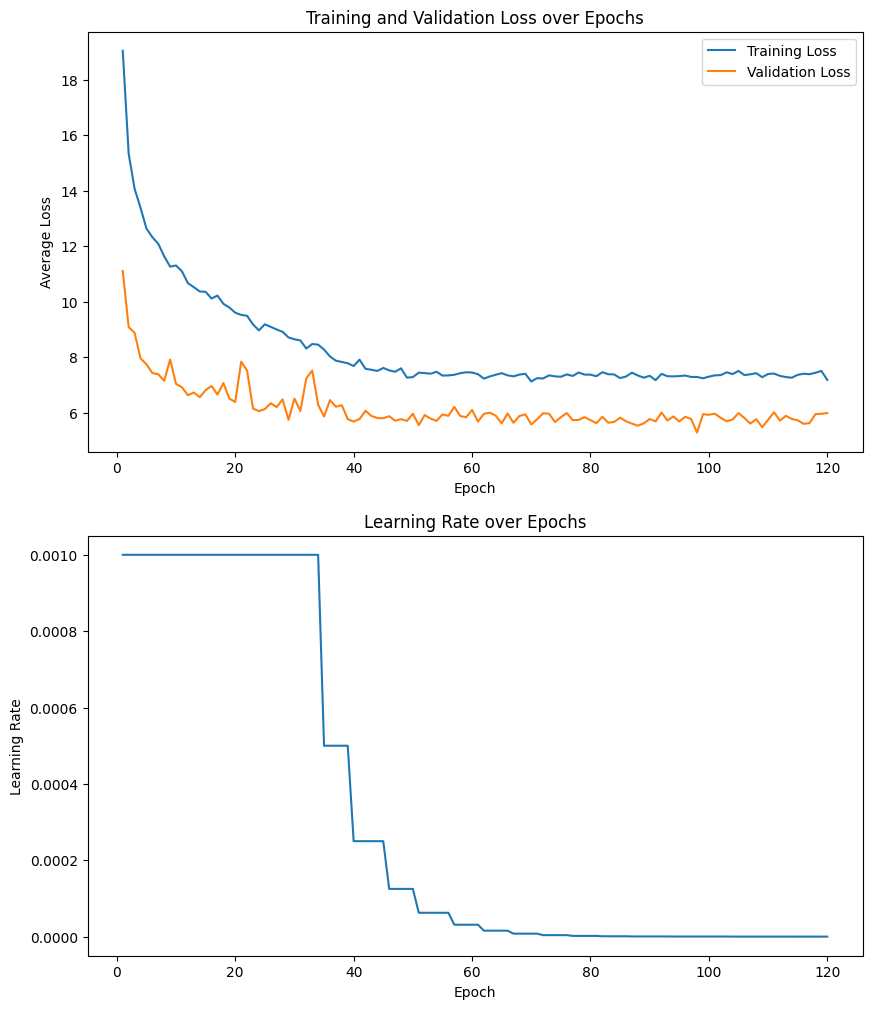

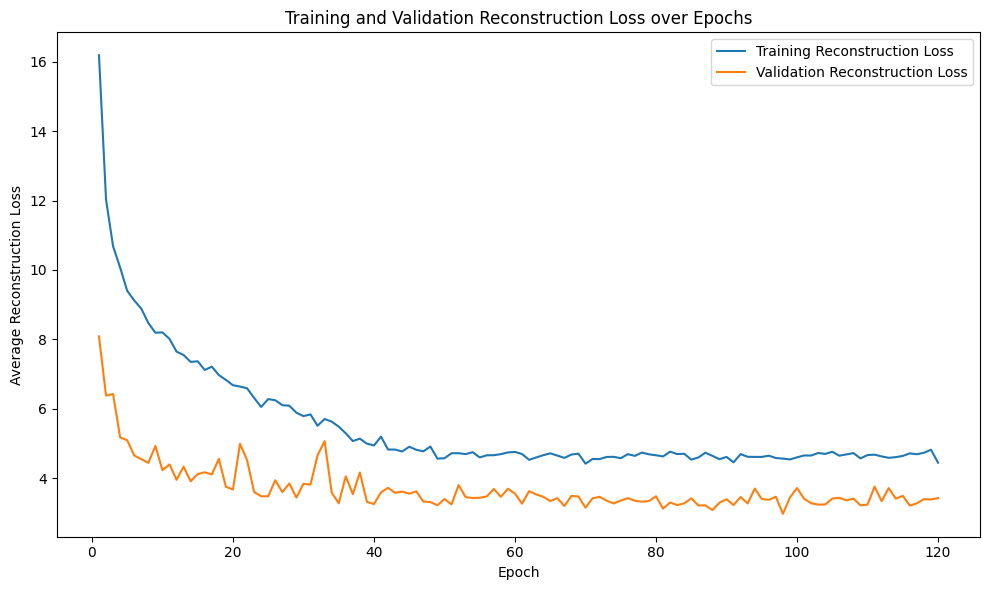

In [88]:
best_train_losses = []
best_val_losses = []
best_train_recon_losses = []
best_val_recon_losses = []
best_train_kl_losses = []
best_val_kl_losses = []
best_train_class_losses = []
best_val_class_losses = []
best_val_accuracies = []
best_learning_rates = []

best_best_loss = float('inf')
best_best_val_accuracy = 0


for epoch in range(1, num_epochs + 1):
    # Training step
    train_loss, train_recon, train_kl, train_class, train_accuracy = train_supervised(best_model, optimizer, scheduler, epoch, beta, gamma)
    
    # Validation step
    val_loss, val_recon, val_kl, val_class, val_accuracy = validate_supervised(best_model, optimizer, scheduler, epoch, beta, gamma)
    
    # Track losses and accuracy
    best_train_losses.append(train_loss)
    best_val_losses.append(val_loss)
    best_train_recon_losses.append(train_recon)
    best_val_recon_losses.append(val_recon)
    best_train_kl_losses.append(train_kl)
    best_val_kl_losses.append(val_kl)
    best_train_class_losses.append(train_class)
    best_val_class_losses.append(val_class)
    best_val_accuracies.append(val_accuracy)
    best_learning_rates.append(optimizer.param_groups[0]['lr'])
    
    # Scheduler step
    scheduler.step(val_loss)

    # Save the best model based on validation loss
    if val_loss < best_best_loss:
        best_best_loss = val_loss
        torch.save(best_model.state_dict(), 'best_supervised_vae_best_loss.pth')
        print(f"New best model saved with validation loss: {best_best_loss:.4f}")
    
    # Save the best model based on validation accuracy
    if val_accuracy > best_best_val_accuracy:
        best_best_val_accuracy = val_accuracy
        torch.save(best_model.state_dict(), 'best_supervised_vae_best_acc.pth')
        print(f"New best model saved with validation accuracy: {best_best_val_accuracy:.4f}")
    
    # Early stopping
    if early_stopping(best_val_losses, patience):
        print(f"Early stopping triggered at epoch {epoch}")
        break
    

print("Training complete.")

# Plot training and validation loss, learning rates, and reconstruction loss
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot training and validation loss
ax1.plot(range(1, len(best_train_losses) + 1), best_train_losses, label='Training Loss')
ax1.plot(range(1, len(best_val_losses) + 1), best_val_losses, label='Validation Loss')
ax1.set_title('Training and Validation Loss over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Loss')
ax1.legend()

# Plot learning rate
ax2.plot(range(1, len(best_learning_rates) + 1), best_learning_rates)
ax2.set_title('Learning Rate over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Learning Rate')

# Plot the training and validation reconstruction loss
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(1, len(best_train_recon_losses) + 1), best_train_recon_losses, label='Training Reconstruction Loss')
ax.plot(range(1, len(best_val_recon_losses) + 1), best_val_recon_losses, label='Validation Reconstruction Loss')
ax.set_title('Training and Validation Reconstruction Loss over Epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('Average Reconstruction Loss')
ax.legend()

plt.tight_layout()
plt.show()


In [89]:
val_accuracy, val_class_report, val_conf_matrix, val_f1_score = evaluate_classifier(model, val_loader, device)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report:\n", val_class_report)
print("Confusion Matrix:\n", val_conf_matrix)
print(f"Validation F1 Score: {val_f1_score:.4f}")

Validation Accuracy: 0.8667
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.67      0.06      0.11       238
    Repeater       0.87      1.00      0.93      1495

    accuracy                           0.87      1733
   macro avg       0.77      0.53      0.52      1733
weighted avg       0.84      0.87      0.82      1733

Confusion Matrix:
 [[  14  224]
 [   7 1488]]
Validation F1 Score: 0.8154


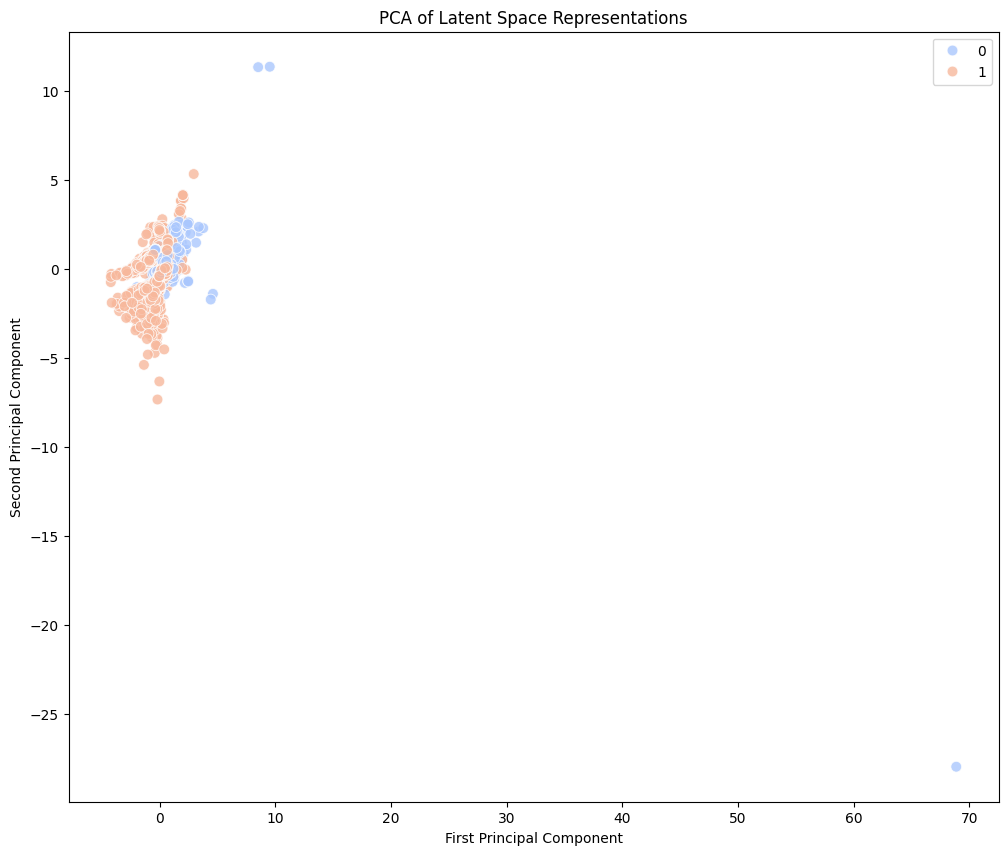

In [90]:
def get_latent_representations(model, dataloader, device):
    model.eval()
    latent_representations = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            mu, _ = model.encode(data)
            latent_representations.append(mu.cpu().numpy())
            all_labels.append(labels.numpy())
    return np.concatenate(latent_representations), np.concatenate(all_labels)


def visualize_latent_space_pca(latent_representations, labels, model, device):
    # Perform PCA
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_representations)

    # Plot the 2D latent space
    plt.figure(figsize=(12, 10))
    #scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='plasma', s=10)
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=labels, palette='coolwarm', s=60, alpha=0.8)
    plt.title('PCA of Latent Space Representations')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

train_latent, train_labels_np = get_latent_representations(best_model, train_loader, device)
visualize_latent_space_pca(train_latent, train_labels_np, best_model, device)